# Project "Elements Logiciels pour le Traitement de Données Massives"

Nicolas TILQUIN & Guillaume RIGAUD

## Topic :  "OpenMP parallelization of multiple precision Taylor series method"


For this project, we studied the article of S.DIMOVA and al from 2019 (https://arxiv.org/pdf/1908.09301.pdf). 
The problem considered is achieving a reliable long-term solution of chaotical dynamical system through a robust numerical procedure. This task is difficult due to the sensitivity of the system to its initial conditions. 

As in the article, we take the Lorentz equations as example. The Lorentz model is a system of three 1st order differential equations. It was developed by Lorentz as a simplified model for convection processes in the atmosphere, with the goal of studying weather-related phenomena. The model consists of the following differential equations :  
$ \frac{dx}{dt} = \sigma(y$ - $x)  $  <br/>
$ \frac{dy}{dt} =Rx$ − $y$ − $xz  $ <br/>
$\frac{dz}{dt} = xy$ − $bz  $ <br/>

Constructing robust and clean numerical procedure for computing solutions is an advantage for weather predictions. Indeed, when a small variations in initial conditions occurs, the solution remains quite stable, but for a short finite time only:  it becomes impossible to forecast for a long time span. This implies computing again the solution at each variation of the initial conditions.

Plan : 
- 1 Introduction and parameters set up
- 2 Sequential code
- 3 Parallelization with OpenMP and Cython
- 4 Applications

# 1. Introduction and Parameters set up 



#### Parameters set up 
We set the parameters to : $R = 28, \sigma = 10 , b = \frac{8}{3} $. For these values, the model is chaotic.
We need to fix our study to a time interval  [0, $T_{c}$]. The goal is to compute as fast as possible the coordinates of our point at time $T_{c}$, with an error tolerance of $K$. To do so, we need to find the the optimal order $N$ of the Taylor polynomial used in the numerical approximation. 


#### Comments on the research paper

In the research paper, results were computed with 28 cores. The time span is [0,1200] with a step equal to 0.01 and an 400th order Taylor polynomial. The error tolerance was fixed to 800 decimals digits. Those set up led to a computing time of 9.8 hours with sequential code, and 0.75 hours with parallel code. 


In this project, we couldn't let our computer run for such a long time. It would take a too long to evaluate the performance of the parallel code with the same paramaters as the one used in the paper. With a timer function, the program is called several times to get a more robust measure of the performances of our code :  this proceedure takes much longer time. 

The problem studied isn't made for parallelisation : the particle's next stage depends on the previous one. Therefore, parallelisation can only be done for one step at a time. This causes the parallelisation to be relevent and usefull only if the order N of the Polynomial is high. If $N$ is low, parallelization has no effect : the dot product that we compute in parallele is too small. If $N$ is high and the time span is low (or the time interval high), the parallelisation is used only a few times and it is difficult to measure the gain. When $T_{c}$ and $N$ are both large, parrallelization on a large dot product is called several times and can thus improve considerably the results. 

In order to be able to show a few results, we chose to set $T_{c}$ low and N quite large.
We didn't compute the dot product manually, but chose to take the Numpy dot product as a benchmark : any improvment on this really fast dot product will be considered as relevent.


We set  $T_{c} = 3$ and  $K = 10^{-6}$ to get a reasonable running time. We will first compute the running time of different approaches before using the fastes one to compute the optimal $N$.  We try to find $N$ with our simple sequential code, and check if $N$ is valid for other initial conditions.


# 2. Sequential code

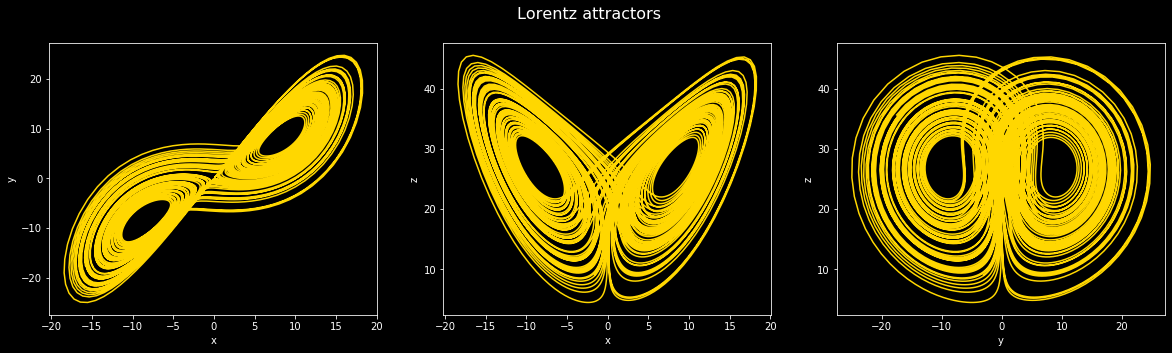

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from python_functions import lorentz_resolution_seq # our function for lorentz system resolution 
from python_functions import mesure_time_dim, mesure_time
plt.style.use('dark_background')

x , y , z = lorentz_resolution_seq(R = 28, sigma = 10 , b = 8/3, x_0 = -15.8, y_0 = -17.48,
                                         z_0 = 35.64 , N = 4, T_c = 100, step = 0.01)

fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(x, y, color = 'gold')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].plot(x, z, color = 'gold')
ax[1].set_xlabel('x')
ax[1].set_ylabel('z')
ax[2].plot(y, z, color = 'gold')
ax[2].set_xlabel('y')
ax[2].set_ylabel('z')
fig.suptitle('Lorentz attractors', fontsize = 16)
plt.show()

In [2]:
%timeit lorentz_resolution_seq(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = 100, T_c = 2, step = 0.01)

518 ms ± 77.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Lets define a grid of $N$ for which we will test the speed : 

In [3]:
N_test = range(10,411,50)

In [4]:
from python_functions import mesure_time_dim
from python_functions import mesure_time
ctxs = [dict(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = n, T_c = 3, step = 0.01,
             fonction = lorentz_resolution_seq,
             ordre_name = n)
             for n in N_test ]


res_lorentz_seq = list(mesure_time_dim("fonction(R,sigma, b, x_0, y_0, z_0, N, T_c, step)",ctxs,
                                   nom_fonction = "lorentz_resolution_seq", repeat=2, number=4))

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/guillaumerigaud/Documents/Ensae/S1/ELTDM/ProjetELMT/python_functions.py:49: RuntimeWarning: invalid value encountered in double_scalars
  beta[i+1] = div * ( R * alpha[i] - beta[i] - np.sum(alpha[:(i+1)][::-1] * gamma[:(i+1)]  ))
/Users/guillaumerigaud/Documents/Ensae/S1/ELTDM/ProjetELMT/python_functions.py:49: RuntimeWarning: overflow encountered in multiply
  beta[i+1] = div * ( R * alpha[i] - beta[i] - np.sum(alpha[:(i+1)][::-1] * gamma[:(i+1)]  ))
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/guillaumerigaud/Documents/Ensae/S1/ELTDM/ProjetELMT/python_functions.py:50: RuntimeWarning: overflow encountered in multiply
  gamma[i+1] = div * ( np.sum( alpha[:(i+1

Sometimes, doubles are too large to be well stored by a non multi precision librairy : this is the case for high N, but for the moment we only care about computation time rather than accuracy.
In our set up, we will see later that for lower optimal N we don't have any problem. 

We provided .pyx and .so compiled files, if you do not use mac OS, please erase those files and run again the get_pyx_files.ipynb to generate those files with their right compiled version. 

In [5]:
%load_ext Cython

In [6]:
%%cython 
cimport cython
import pyximport 
import numpy as np 
from lorentz_seqc import lorentz_resolution_seqc

In [7]:
%timeit lorentz_resolution_seqc(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = 100, T_c = 3, step = 0.01)

746 ms ± 50.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
ctxs = [dict(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = n, T_c = 3, 
             step = 0.01,
             fonction = lorentz_resolution_seqc,
             ordre_name = n)
             for n in N_test ]

res_lorentz_seqc = list(mesure_time_dim("fonction(R,sigma, b, x_0, y_0, z_0, N, T_c, step)",ctxs,
                                   nom_fonction = "lorentz_resolution_seqc", repeat=2, number=4))

<string>:6: RuntimeWarning: invalid value encountered in double_scalars
<string>:6: RuntimeWarning: overflow encountered in multiply
<string>:6: RuntimeWarning: invalid value encountered in multiply


In [9]:
import pandas as pd
from pandas import concat
#Transformation en DataFrame
df1 = pd.DataFrame(res_lorentz_seq)
df1["fct"] = "Python Numpy"
df2 = pd.DataFrame(res_lorentz_seqc)
df2["fct"] = "Cython Numpy"

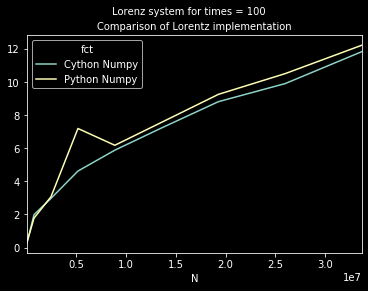

In [10]:
import matplotlib.pyplot as plt

def get_N_comp(T_c, step, N):
    return( (T_c / step )*( N**2 +N ))

cc = concat([df1, df2])
cc["N"] = cc["ordre_name"]
cc["N"] = get_N_comp(2, 0.01, cc.N )
fig, ax = plt.subplots(1, 1, figsize=(6,4))

#cc[cc.N <=200].pivot('N', 'fct','average').plot(logy=True, logx=True, ax = ax[0])
cc.pivot('N', 'fct','average').plot( ax = ax)


ax.set_title("Comparison of Lorentz implementation", fontsize = 10)
#ax[1].set_title("Comparison of Lorentz without Python", fontsize = 10)
fig.suptitle('Lorenz system for times = 100', fontsize = 10)
plt.style.use('dark_background')
plt.show()

The cython function is faster but not from a lot because we haven't declared types in the cython script.
Let's jump to the parallel code.

# 3. Parallelization with OpenMP and Cython

The parallelization will allow us to build a program that will perform the specified tasks in parallel unlike the usual process where each task is performed sequentially. For this, we will use the OPENMP API which is available for the language C, C ++... We use this API through Cython.The advantage of using cython is that it is a compiled language and therefore it is directly transformed into machine language, which makes it possible to be faster than interpreted languages such as python.


In [11]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url='https://www.guru99.com/images/1/053018_0616_CompilervsI1.png')

In this section we try to get faster results. To do so, we use the fork join model. 

We started by computing only the two dot products inside the second loop in parallel. As mentioned before, since the problem is path dependent, this is the only operation we can do in parallel. 

### Parallelization as in the paper

In [12]:
%%cython 
import pyximport 
import numpy as np 
from lorentz_omp import lorentz_resolution_omp

In [13]:
%timeit lorentz_resolution_omp(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = 100, T_c = 3, step = 0.01)

460 ms ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
ctxs = [dict(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = n, T_c = 3, 
             step = 0.01,
             fonction = lorentz_resolution_omp,
             ordre_name = n)
             for n in N_test]

res_lorentz_omp = list(mesure_time_dim("fonction(R,sigma, b, x_0, y_0, z_0, N, T_c, step)",ctxs,
                                   nom_fonction = "lorentz_resolution_omp", repeat=2, number=4))

<string>:6: RuntimeWarning: invalid value encountered in double_scalars
<string>:6: RuntimeWarning: invalid value encountered in multiply


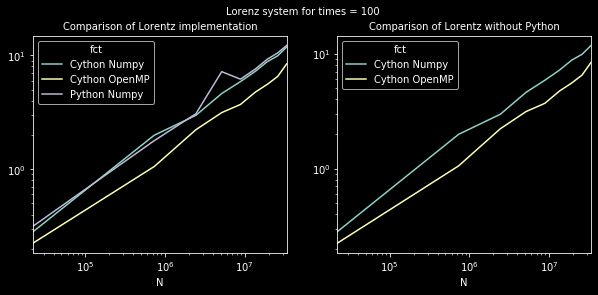

In [15]:
df3 = pd.DataFrame(res_lorentz_omp)
df3["fct"] = "Cython OpenMP"

cc = concat([df1, df2, df3])
cc["N"] = cc["ordre_name"]
cc["N"] = get_N_comp(2, 0.01, cc.N )
fig, ax = plt.subplots(1, 2, figsize=(10,4))

#cc[cc.N <=200].pivot('N', 'fct','average').plot(logy=True, logx=True, ax = ax[0])
cc.pivot('N', 'fct','average').plot(logy=True, logx=True, ax = ax[0])


cc[cc.fct !='Python Numpy'].pivot('N', 'fct', 'average').plot(logy=True, logx=True, ax = ax[1])
ax[0].set_title("Comparison of Lorentz implementation", fontsize = 10)
ax[1].set_title("Comparison of Lorentz without Python", fontsize = 10)
fig.suptitle('Lorenz system for times = 100', fontsize = 10)
plt.style.use('dark_background')
plt.show()

### Parallelization of the two last dot products

Here we also try to parallelized the last dot product, to see if we have some gains of speed even if it is negligible in front of the complexity of the algorithm. 

In [16]:
%%cython 
import pyximport 
import numpy as np 
from lorentz_ompfull import lorentz_resolution_ompfull

In [17]:
%timeit lorentz_resolution_omp(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = 100, T_c = 2, step = 0.01)

413 ms ± 41.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
ctxs = [dict(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = n, T_c = 3,
             step = 0.01,
             fonction = lorentz_resolution_ompfull,
             ordre_name = n)
             for n in N_test]

res_lorentz_ompfull = list(mesure_time_dim("fonction(R,sigma, b, x_0, y_0, z_0, N, T_c, step)",ctxs,
                                   nom_fonction = "lorentz_resolution_ompfull", repeat=2, number=4))

<string>:6: RuntimeWarning: invalid value encountered in double_scalars


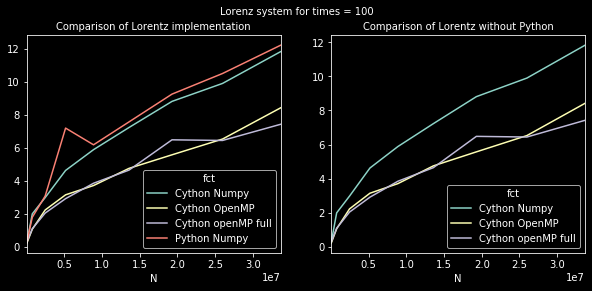

In [19]:
df4 = pd.DataFrame(res_lorentz_ompfull)
df4["fct"] = "Cython openMP full"

cc = concat([df1, df2, df3, df4])
cc["N"] = cc["ordre_name"]
cc["N"] = get_N_comp(2, 0.01, cc.N )
fig, ax = plt.subplots(1, 2, figsize=(10,4))

#cc[cc.N <=200].pivot('N', 'fct','average').plot(logy=True, logx=True, ax = ax[0])
cc.pivot('N', 'fct','average').plot( ax = ax[0])


cc[cc.fct !='Python Numpy'].pivot('N', 'fct', 'average').plot( ax = ax[1])
ax[0].set_title("Comparison of Lorentz implementation", fontsize = 10)
ax[1].set_title("Comparison of Lorentz without Python", fontsize = 10)
fig.suptitle('Lorenz system for times = 100', fontsize = 10)
plt.style.use('dark_background')
plt.show()

As we can see, the parallelization of the dod product added at the end of the code doesnt really improve the results. We are satisfied since parallelization enabled us to beat Numpy. Maybe if we worked on the chunk size and threads we would get better results.  We will use the openmp function and try two configurations : static and dynamic, each one with a loop over the chunksize. 

### Static vs Dynamic

In [20]:
#Static
ctxs = [dict(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = 300, T_c = 3, 
             step = 0.01,chunksize=n, schedule=1,
             fonction = lorentz_resolution_omp,
             ordre_name = n)
             for n in range(8,64,8)]

res_lorentz_ompfullSch1 = list(mesure_time_dim("fonction(R,sigma, b, x_0, y_0, z_0, N, T_c, step, chunksize, schedule)",ctxs,
                                   nom_fonction = "lorentz_resolution_omp", repeat=2, number=4))

In [21]:
#dynamic
ctxs = [dict(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = 300, T_c = 3,
             step = 0.01,chunksize=n, schedule=2,
             fonction = lorentz_resolution_omp,
             ordre_name = n)
             for n in range(8,64,8)]

res_lorentz_ompfullSch2 = list(mesure_time_dim("fonction(R,sigma, b, x_0, y_0, z_0, N, T_c, step, chunksize, schedule)",ctxs,
                                   nom_fonction = "lorentz_resolution_omp", repeat=2, number=4))

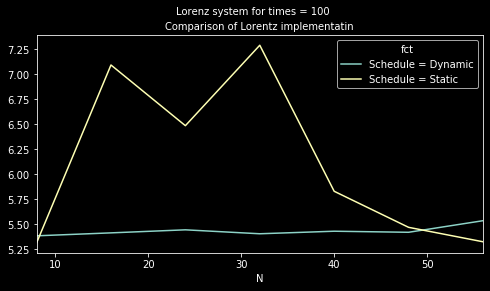

In [22]:
sch1 = pd.DataFrame(res_lorentz_ompfullSch1)
sch1["fct"] = "Schedule = Static"
sch2 = pd.DataFrame(res_lorentz_ompfullSch2)
sch2["fct"] = "Schedule = Dynamic"
compSch = concat([sch1,sch2])


compSch["N"] = compSch["ordre_name"]
fig, ax = plt.subplots(1, 1, figsize=(8,4))

compSch.pivot('N', 'fct','average').plot( ax = ax)

ax.set_title("Comparison of Lorentz implementatin", fontsize = 10)
fig.suptitle('Lorenz system for times = 100', fontsize = 10)
plt.style.use('dark_background')
plt.show()

For this value of $N$, the schedule Dynamic associated to chunksize = 32 seems to be the best setup (depending on the runs). We run one last time the simulations with this configuration. We let the the num thread to its default value (our number of cores). If the num of threads is higher than the number of cores, each core will compute several order of operations (chunk). 

For example, assume we have 32*8 operations to compute and that we have 4 cores. With chunksize  = 32 each and a 4 cores CPU , each core will compute 2 sequences of 32 chunks. The number of threads is total number of operations divided by the chunksize. If we want to fix manually both the chunk size and the number of threads, we have to find a multiples of the total numer of operations. 

To find a better number of threads than the one computed by default, we would have to study deeper the configuration of our CPU (CPU bound, memory bound and I/O bound). Here, since computations required are all of the same complexity (simple product), we don't have any better idea than to devide equally the number of operations between threads. 

In [23]:
ctxs = [dict(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, z_0 = 35.64, N = n , T_c = 3, step = 0.01,chunksize=16, schedule=2,
             fonction = lorentz_resolution_omp,
             ordre_name = n)
             for n in N_test ]

res_lorentz_ompdynamic = list(mesure_time_dim("fonction(R,sigma, b, x_0, y_0, z_0, N, T_c, step, chunksize, schedule)",ctxs,
                                   nom_fonction = "lorentz_resolution_omp", repeat=2, number=4))

<string>:6: RuntimeWarning: invalid value encountered in double_scalars
<string>:6: RuntimeWarning: invalid value encountered in multiply


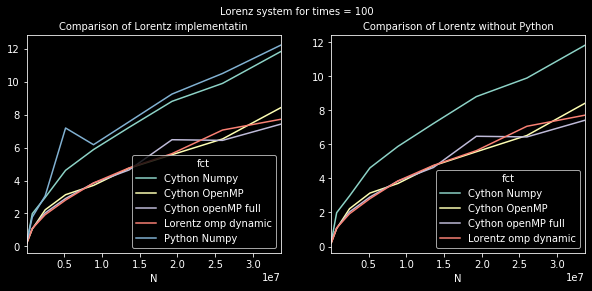

In [24]:
df5 = pd.DataFrame(res_lorentz_ompdynamic)
df5["fct"] = "Lorentz omp dynamic"

cc = concat([df1, df2, df3, df4, df5])
cc["N"] = cc["ordre_name"]
cc["N"] = get_N_comp(2, 0.01, cc.N )
fig, ax = plt.subplots(1, 2, figsize=(10,4))

#cc[cc.N <=200].pivot('N', 'fct','average').plot(logy=True, logx=True, ax = ax[0])
cc.pivot('N', 'fct','average').plot( ax = ax[0])


cc[cc.fct !='Python Numpy'].pivot('N', 'fct', 'average').plot( ax = ax[1])
ax[0].set_title("Comparison of Lorentz implementatin", fontsize = 10)
ax[1].set_title("Comparison of Lorentz without Python", fontsize = 10)
fig.suptitle('Lorenz system for times = 100', fontsize = 10)
plt.style.use('dark_background')
plt.show()

# 4. Applications

## Quick 'clean simulation'

The really high $N$ used before was to illustrate the time gain when parallelizing the algorithm. Such a high $N$ is only usefull if we use a multiple precision library. 

We find the optimal $N$ order for a $T_{c}$ = 100 and $K = 10^{-6}$ tolerance error. Our tolerance error is quite low compared to the one used in the paper. This low tolerance allows us to look at a longer time span, and use a lower $N$. 

In [25]:
# create empty tables

x = np.ndarray( (int(100/0.01)+2, 23) )
y = np.ndarray((int(100/0.01)+2, 23))
z = np.ndarray(( int(100/0.01)+2, 23))


n_vec = np.arange(1,24,1)

for n in  n_vec : 
    col = n-1
    x[:,col], y[:,col], z[:,col] = lorentz_resolution_omp(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, 
                       z_0 = 35.64, N = n , T_c = 100, step = 0.01, chunksize = 16, schedule = 2)



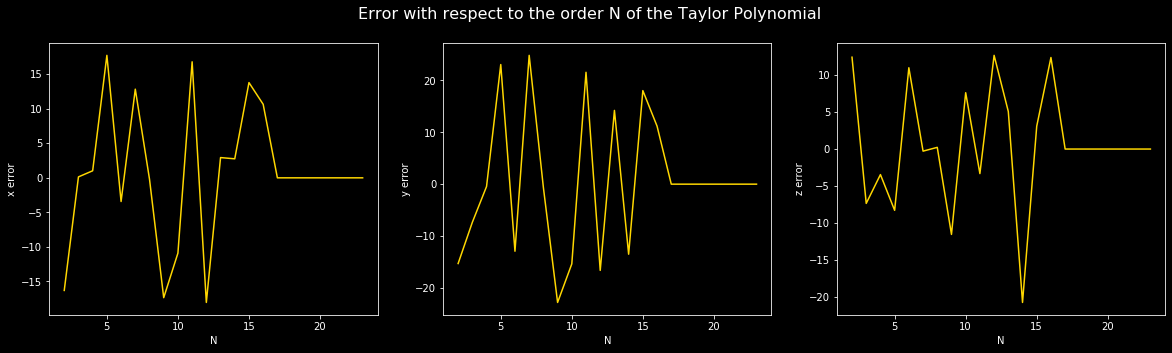

In [26]:
# plot the convergence of coordinates : we compute the difference beetween last positions of the particule

diff = pd.DataFrame( {'x' : x[int(100/0.01)+1, : ], 'y' : y[int(100/0.01)+1, : ] ,
                      'z' : z[int(100/0.01)+1, : ] }).diff(1)


#plt.plot( n_vec , diff.x) 

fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(n_vec , diff.x , color = 'gold')
ax[0].set_xlabel('N')
ax[0].set_ylabel('x error')
ax[1].plot(n_vec, diff.y, color = 'gold')
ax[1].set_xlabel('N')
ax[1].set_ylabel('y error')
ax[2].plot(n_vec, diff.z, color = 'gold')
ax[2].set_xlabel('N')
ax[2].set_ylabel('z error')
fig.suptitle('Error with respect to the order N of the Taylor Polynomial', fontsize = 16)
plt.show()

In [27]:
# print the errors, we indid have or K tolerance of error attained when N>16
diff

,x,y,z
0,NaN,NaN,NaN
1,-16.303403,-15.310124,12.427901
2,0.137122,-7.358287,-7.356615
3,1.020867,-0.450010,-3.455750
4,17.732530,23.072748,-8.290467
5,-3.429199,-12.936381,11.001448
6,12.837389,24.847251,-0.282156
7,-0.191958,-0.641458,0.228468
8,-17.350104,-22.817797,-11.552391
9,-10.900593,-15.377717,7.623167



## A chaotic system: illustration

Now that we have a fast way to compute clean solutions, we can play around with the inital conditions. When we move the initial condition of +1%, what happens to the final point? We are not sure to be able to show it here, since the systems becomes chaotic after a certain time period.

We use a higher N than necessary to be sure to get a clean simulation

In [28]:
x, y, z = lorentz_resolution_omp(R = 28, sigma = 10, b = 8/3, x_0 = -15.8, y_0 = -17.48, 
                       z_0 = 35.64, N = 20 , T_c = 100, step = 0.01, chunksize = 16, schedule = 2)


a,b,c = lorentz_resolution_omp(R = 28, sigma = 10, b = 8/3, x_0 = -15.8*1.01, y_0 = -17.48*1.01, 
                       z_0 = 35.64*1.01, N = 20 , T_c = 100, step = 0.01, chunksize = 16, schedule = 2)



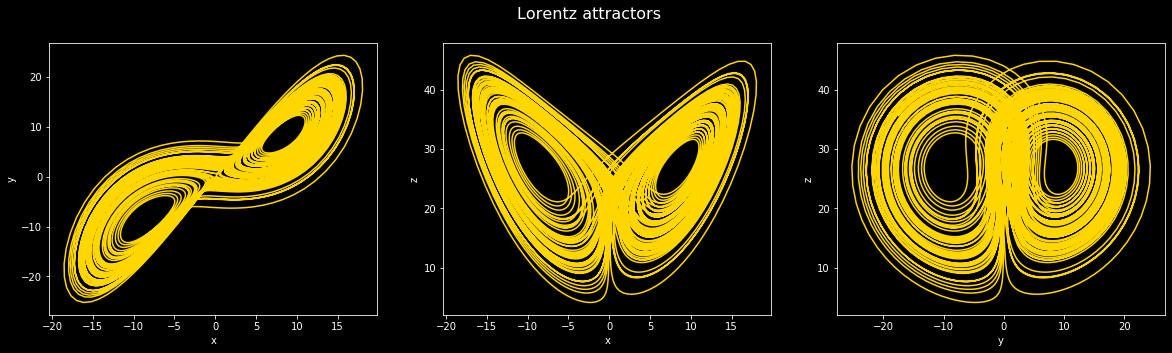

In [29]:
#same as first plot

fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(x, y, color = 'gold')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].plot(x, z, color = 'gold')
ax[1].set_xlabel('x')
ax[1].set_ylabel('z')
ax[2].plot(y, z, color = 'gold')
ax[2].set_xlabel('y')
ax[2].set_ylabel('z')
fig.suptitle('Lorentz attractors', fontsize = 16)
plt.show()

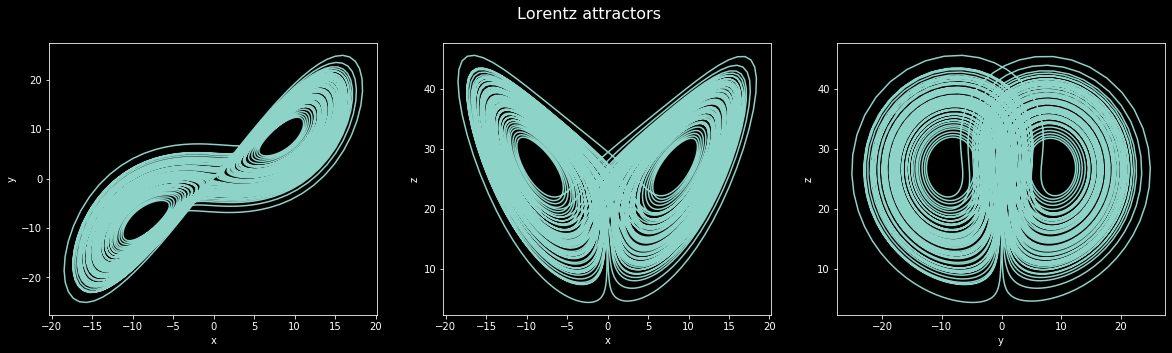

In [30]:
fig, ax = plt.subplots(1,3, figsize = (20,5))
ax[0].plot(a, b)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].plot(a, c)
ax[1].set_xlabel('x')
ax[1].set_ylabel('z')
ax[2].plot(b, c)
ax[2].set_xlabel('y')
ax[2].set_ylabel('z')
fig.suptitle('Lorentz attractors', fontsize = 16)
plt.show()

Although the graphs seem similar, the point is in a quite different state : let's compute the L2 disctance on the initial points and the final points. 

In [31]:
# distance between initial points : 
np.sqrt( (x[0]-a[0])**2 + (y[0]-b[0])**2 + (z[0]- c[0])**2)

0.42724700115975156

In [32]:
# distance in the end : 
m = len(x)-1
np.sqrt( (x[m]-a[m])**2 + (y[m]-b[m])**2 + (z[m]- c[m])**2)

39.47727838410884

We see indeed that an initial variation of 1% on each coordinates, making both points initially distant from 0.42 makes already a big difference at time 100, the L2 distance is indeed 39.47